In [1]:
from sklearn import tree
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import graphviz 
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from pysupwsdpocket import PySupWSDPocket

# load data

In [2]:
hs = pd.read_csv("./TempData/model_data.csv")
print(hs.info())
mlma = pd.read_csv("./TempData/mlma_dataset.csv")
print(mlma.info())
hasoc = pd.read_csv("./TempData/hasoc2019_data.csv",delimiter="\t")
print(hasoc.info())
df = pd.concat([hs,mlma, hasoc], axis=0, ignore_index=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3701 non-null   int64 
 1   text        3701 non-null   object
 2   label       3701 non-null   object
dtypes: int64(1), object(2)
memory usage: 86.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5647 non-null   int64 
 1   text        5647 non-null   object
 2   label       5647 non-null   object
dtypes: int64(1), object(2)
memory usage: 132.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2306 non-null   object
 1   text        2306 non-null   object
 2   labe

In [3]:
df.drop_duplicates(subset="text",keep='first')
df = df[~df['text'].str.split().str.len().lt(3)]

df.head(20)

,Unnamed: 0,text,label
0,0,These girls are the equivalent of the irritati...,racism
1,1,Who is writing the bimbolines? #mkr,sexism
2,2,"Colin will save them. They're pretty blondes, ...",sexism
3,3,Which will end first: #mkr or Tony Abbott as PM?,none
4,4,RT @TheAngelaOfOz: That's bullshit Colin and y...,none
5,5,Drasko they didn't cook half a bird you idiot ...,racism
6,6,Drasko they didn't cook half a bird you idiot ...,none
7,7,Drasko they didn't cook half a bird you idiot ...,racism
8,8,Drasko they didn't cook half a bird you idiot ...,none
9,9,Stop saying dumb blondes with pretty faces as ...,sexism


# load models and stopwords
For getting pysupwsdpocket to work it is necessary to [Download](https://supwsd.net/supwsd/downloads.jsp) the SupWSD Pocket model for english to the path: ```/home/your_user/pysupwsdpocket_models```

In [4]:
nlp = PySupWSDPocket(lang='en', model='semcor_omsti')
vectorizer = CountVectorizer()
stop_words = set(stopwords.words('english')) 

# Data preparation

In [15]:
corpus = []
# Y = np.zeros(len(df['id']), dtype=int)
Y = []
tweet_ids = []
all_senses = []
for idx, row in df.iterrows():
    print(row['text'])
    doc = nlp.wsd(" ".join(row['text'].splitlines()))
    # doc = nlp.wsd(row['text']) # word sense disambiguation
    sentence_senses = []
    for token in doc.tokens():
        if token.lemma not in stop_words:
            if token.max_probability()['id'] != 'U':
                sentence_senses.append(token.max_probability()['synset'].name())
                if token.max_probability()['synset'].name() not in all_senses:
                    all_senses.append(token.max_probability()['synset'].name())
    if len(sentence_senses) > 0:
        corpus.append(sentence_senses)
        if row['label'] not in ['none','normal','NOT']:
            Y.append(1)
        else:
            Y.append(0)
        
corpus[:2]


These girls are the equivalent of the irritating Asian girls a couple years ago. Well done, 7. #MKR
Who is writing the bimbolines? #mkr
Colin will save them. They're pretty blondes, as they keep telling us. #mkr
Which will end first: #mkr or Tony Abbott as PM?
RT @TheAngelaOfOz: That's bullshit Colin and you know it. #mkr
Drasko they didn't cook half a bird you idiot #mkr
Drasko they didn't cook half a bird you idiot #mkr
Drasko they didn't cook half a bird you idiot #mkr
Drasko they didn't cook half a bird you idiot #mkr
Stop saying dumb blondes with pretty faces as you need a pretty face to pull that off!!!! #mkr
Obviously natural blondes!! #mkr
R u fucking kidding - catwalk - all that's missing is a pole #mkr
I'm done - won't bother with the rest of this pathetic shit show #mkr
That's just sloppy shit on a plate - deconstructed really - give it up for disaster  #mkr
"I needed a dessert"  #mkr
Fucking rigged - r u kidding they didn't even make a mediocre meal - there was no sass - th

AttributeError: 'IndexError' object has no attribute 'tokens'

In [12]:
X = np.zeros((len(corpus), len(all_senses)))

for idx, item in enumerate(corpus):
    for sense in item:
        X[idx][all_senses.index(sense)] = 1
X.shape

(100, 233)

In [20]:
corpus

['girl.n.01 equivalent.n.01 girl.n.01 couple.n.02 year.n.01 ago.r.01 well.r.01',
 'cook.n.01 one-half.n.01 bird.n.01 idiot.n.01',
 'person.n.01 cook.n.01 following.s.02',
 'naturally.r.01 give_birth.v.01 movie.n.01',
 'lose.v.01 plot.n.01 large.a.01 texan.n.01 elephant.n.01 steak.n.01',
 'state.v.01 impress.v.02 girl.n.01 cook.v.01 one-half.n.01 cook.v.02 whole.a.01 one.n.01',
 'well.r.02 look.v.02 bullshit.n.01 two.n.01',
 'face.n.03 ugly.a.01 girl.n.01 face.n.05 cat.n.01 excite.v.01 see.v.01 tonight.r.01',
 'elegant.a.01 nothing.n.01 unattractive.s.02 female_child.n.01 slam.v.02 hot.a.01',
 'restaurant.n.01 beard.n.01 make.v.02 look_like.v.01 laugh.v.01',
 'discontinue.v.01 allege.v.01 dense.s.04 blond.n.01 pretty.s.01 face.n.05 want.v.02 pretty.s.01 face.n.05 pull.v.01',
 'restaurant.n.01 look_like.v.01 small.a.01 female_child.n.01 room.n.01',
 'like.v.02 hot.a.01 pot.n.01 particularly.r.01 intoxicated.a.01 unconscious.a.01',
 'thaw.n.01 put.v.01 serve.v.07 dense.s.04',
 'girl.n.01 

In [13]:
clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=10)
clf = clf.fit(X, Y)

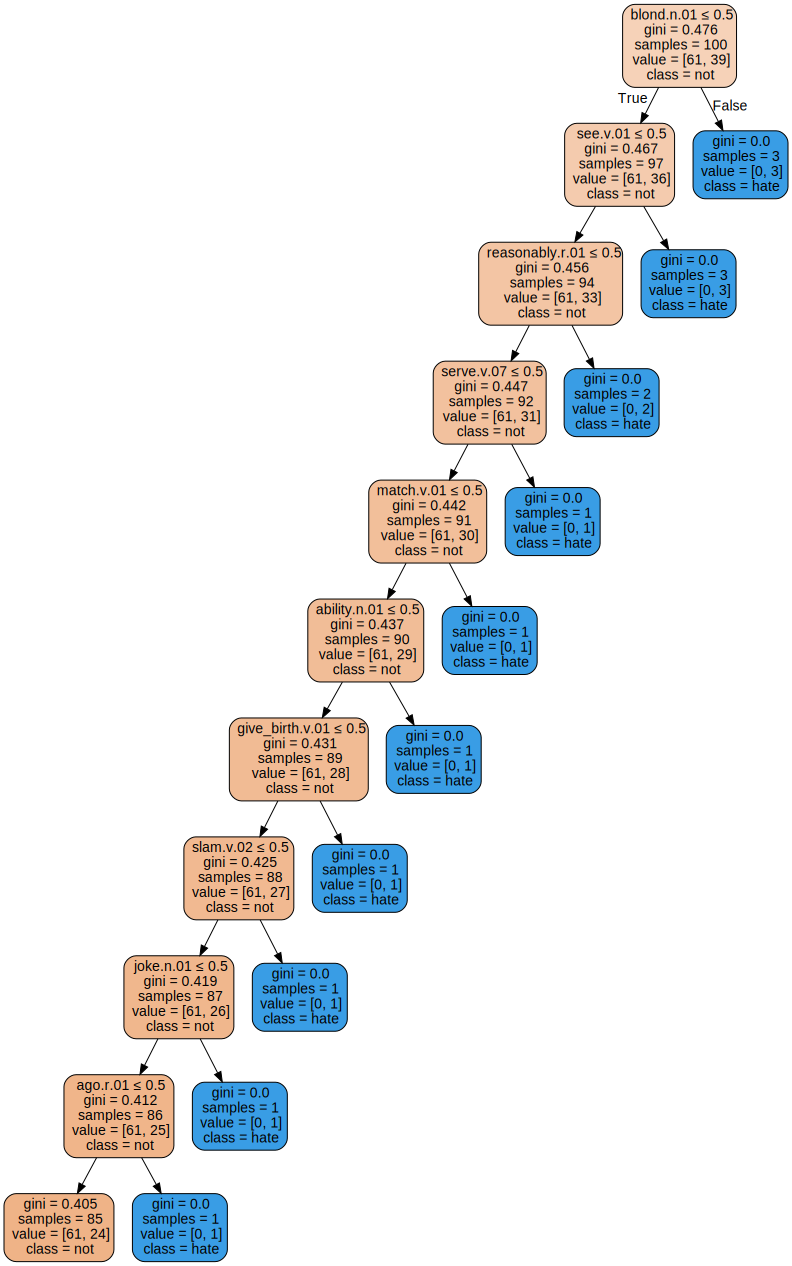

In [14]:
dot_data = tree.export_graphviz(clf, out_file=None,
    class_names=['not','hate'],
    feature_names=all_senses,
    filled=True, rounded=True,  special_characters=True) 

graph = graphviz.Source(dot_data) 
graph.render("./twitter_data/tree") 

display(graphviz.Source(dot_data))